# iCAT Overlay
---

In [146]:
from pathlib import Path
from itertools import product
from pprint import pprint

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from shapely.geometry import box
from shapely import affinity
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D

from skimage.external.tifffile import TiffFile, imread

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.transform import AffineModel as AffineRender

from icatapi.render_pandas import *
from icatapi.overlay import *

#### Settings

In [ ]:
# pandas display settings
# -----------------------
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

## Set up `render-ws` environment
---

In [429]:
# `render` project parameters
# ---------------------------
owner = 'rlane'  # replace with your name
project = '20191230_RL010'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)

# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]
stacks_2_overlay = stacks_FM
stack_underneath = 'big_EM'

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
stacks to overlay... {stacks_2_overlay}
stack underneath.... {stack_underneath}
...
"""
print(out)

# Create project DataFrame
# ------------------------
df_project = create_project_DataFrame(render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))\
          .drop(['camera', 'temca'], axis=1)

all stacks.......... ['lil_EM', 'insulin', 'hoechst', 'big_EM']
EM stacks........... ['lil_EM', 'big_EM']
FM stacks........... ['insulin', 'hoechst']
stacks to overlay... ['insulin', 'hoechst']
stack underneath.... big_EM
...



tileId    z   width  height  minIntensity  maxIntensity  \
stack                                                                      
big_EM  3185  aag_bi...  8.0  4096.0  4096.0    32168.0       33580.0      
        3180  aab_bi...  8.0  4096.0  4096.0    32168.0       33580.0      
        3177  aak_bi...  7.0  4096.0  4096.0    32174.0       33628.0      
hoechst 3024  aab_ho...  4.0  2048.0  2048.0      833.0        1666.0      
        3036  aab_ho...  5.0  2048.0  2048.0      833.0        1666.0      
        3005  aag_ho...  2.0  2048.0  2048.0      834.0        1668.0      
insulin 2910  aah_in...  3.0  2048.0  2048.0      424.0         848.0      
        2879  aaa_in...  1.0  2048.0  2048.0      431.0         862.0      
        2902  aal_in...  2.0  2048.0  2048.0      421.0         842.0      
lil_EM  1533  ajt_li...  5.0  4096.0  4096.0    30992.0       33239.0      
        1973  acc_li...  7.0  4096.0  4096.0    30955.0       32994.0      
        770   afa_li...  3.0  4096.0  4096.0    30980.0       33008.0      

                stack sectionId  imageRow  imageCol     stageX     stageY  \
stack                                                                       
big_EM  3185   big_EM      S008         1         0  3256.1...  6381.3...   
        3180   big_EM      S008         3         1  3446.4...  5992.1...   
        3177   big_EM      S007         0         1  2831.4...  6576.0...   
hoechst 3024  hoechst      S004         3         1  1026.2...  5981.7...   
        3036  hoechst      S005         3         1  1622.7...  5991.2...   
        3005  hoechst      S002         1         0 -361.65...  6315.4...   
insulin 2910  insulin      S003         1         1  419.83...  6341.0...   
        2879  insulin      S001         3         0 -951.98...  5905.6...   
        2902  insulin      S002         0         0 -362.09...  6510.3...   
lil_EM  1533   lil_EM      S005         4         1  1587.9...  6378.2...   
        1973   lil_EM      S007        16         9  2926.7...  6155.0...   
        770    lil_EM      S003        11         2  407.67...  6227.2...   

               imageUrl transforms  
stack                               
big_EM  3185  file:/...  [M=[[1...  
        3180  file:/...  [M=[[1...  
        3177  file:/...  [M=[[1...  
hoechst 3024  file:/...  [M=[[1...  
        3036  file:/...  [M=[[1...  
        3005  file:/...  [M=[[1...  
insulin 2910  file:/...  [M=[[1...  
        2879  file:/...  [M=[[1...  
        2902  file:/...  [M=[[1...  
lil_EM  1533  file:/...  [M=[[1...  
        1973  file:/...  [M=[[1...  
        770   file:/...  [M=[[1...

## Compute overlay transforms
---

### Sample overlay transform

In [430]:
# Choose random FM image tile filepath
fp = Path(df_project.loc[df_project['stack'].isin(stacks_FM + [stack_underneath])]\
                    .sample(1)['imageUrl']\
                    .str.split('://')\
                    .iloc[0][1])

# Test parser
(psx, psy), ro, sh, (trx, try_) = get_transform_metadata(fp)

# Output
out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... ({1e9*psx:.1f}nm, {1e9*psy:.1f}nm)
Rotation...... {np.rad2deg(ro):.1f}°
Shear......... {sh:.2e}
Translation... ({1e6*trx:.1f}um, {1e6*try_:.1f}um)
"""
print(out)

File.......... hoechst/hoechst-00000x00002.tif
Pixel size.... (106.5nm, 106.5nm)
Rotation...... 353.1°
Shear......... 1.39e-17
Translation... (3256.5um, 6186.1um)



### Compile transform data

In [546]:
# Create multiindex
overlay_cols = ['stack', 'z', 'sectionId',
                'tileId', 'imageRow', 'imageCol',
                'width', 'height',
                'imageUrl', 'transforms',
                'ps', 'ro', 'sh', 'tr',
                'overlay_transforms']
multiindex = np.array(list(product(overlay_cols,
                                   ['EM', 'FM']))).T.tolist()
# Initialize overlay DataFrame
df_overlay = pd.DataFrame(columns=multiindex)

# Loop through overlay stacks
for stack in stacks_2_overlay:
    # Filter to stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Loop through FM tiles
    for i, FM_tile in df_stack.iterrows():

        # Find correlative EM tile
        EM_tile = df_project.loc[(df_project['stack'] == stack_underneath) &\
                                 (df_project['z'] == FM_tile['z']) &\
                                 (df_project['imageRow'] == FM_tile['imageRow']) &\
                                 (df_project['imageCol'] == FM_tile['imageCol'])].iloc[0]

        # Parse tif for transform metadata
        fp_EM = Path(EM_tile['imageUrl'].split('://')[1])
        fp_FM = Path(FM_tile['imageUrl'].split('://')[1])
        ps_EM, ro_EM, sh_EM, tr_EM = get_transform_metadata(fp_EM)
        ps_FM, ro_FM, sh_FM, tr_FM = get_transform_metadata(fp_FM)

        # Build up overlay DataFrame one FM tile at a time
        df_overlay.loc[i, 'stack'] = EM_tile['stack'], FM_tile['stack']
        df_overlay.loc[i, 'z'] = EM_tile['z'], FM_tile['z']
        df_overlay.loc[i, 'sectionId'] = EM_tile['sectionId'], FM_tile['sectionId']
        df_overlay.loc[i, 'tileId'] = EM_tile['tileId'], FM_tile['tileId']
        df_overlay.loc[i, 'imageRow'] = EM_tile['imageRow'], FM_tile['imageRow']
        df_overlay.loc[i, 'imageCol'] = EM_tile['imageCol'], FM_tile['imageCol']
        df_overlay.loc[i, 'width'] = EM_tile['width'], FM_tile['width']
        df_overlay.loc[i, 'height'] = EM_tile['height'], FM_tile['height']
        df_overlay.loc[i, 'imageUrl'] = EM_tile['imageUrl'], FM_tile['imageUrl']
        df_overlay.loc[i, 'transforms'] = [EM_tile['transforms']], [FM_tile['transforms']]
        # Transform metadata
        df_overlay.loc[i, 'ps'] = ps_EM, ps_FM
        df_overlay.loc[i, 'ro'] = ro_EM, ro_FM
        df_overlay.loc[i, 'sh'] = sh_EM, sh_FM
        df_overlay.loc[i, 'tr'] = tr_EM, tr_FM

# Unpack nested transforms
df_overlay[('transforms', 'EM')] = df_overlay[('transforms', 'EM')].apply(lambda x: x[0])
df_overlay[('transforms', 'FM')] = df_overlay[('transforms', 'FM')].apply(lambda x: x[0])

# Preview
pd.set_option('display.max_colwidth', 15)
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.sample(4))\
          .drop(['ps', 'ro', 'sh', 'tr',
                 'overlay_transforms'], level=0, axis=1)

stack             z      sectionId                tileId  \
                      EM       FM   EM   FM        EM    FM              EM   
(stack, FM)                                                                   
hoechst     3063  big_EM  hoechst  7.0  7.0      S007  S007  aae_big_EM-...   
            3045  big_EM  hoechst  5.0  5.0      S005  S005  aak_big_EM-...   
            3078  big_EM  hoechst  8.0  8.0      S008  S008  aah_big_EM-...   
            3017  big_EM  hoechst  3.0  3.0      S003  S003  aag_big_EM-...   
insulin     2923  big_EM  insulin  4.0  4.0      S004  S004  aai_big_EM-...   
            2944  big_EM  insulin  6.0  6.0      S006  S006  aaf_big_EM-...   
            2884  big_EM  insulin  1.0  1.0      S001  S001  aaf_big_EM-...   
            2960  big_EM  insulin  7.0  7.0      S007  S007  aaj_big_EM-...   

                                 imageRow      imageCol        width          \
                              FM       EM   FM       EM   FM      EM      FM   
(stack, FM)                                                                    
hoechst     3063  aae_hoechst...      2.0  2.0      1.0  1.0  4096.0  2048.0   
            3045  aak_hoechst...      0.0  0.0      1.0  1.0  4096.0  2048.0   
            3078  aah_hoechst...      1.0  1.0      1.0  1.0  4096.0  2048.0   
            3017  aag_hoechst...      1.0  1.0      0.0  0.0  4096.0  2048.0   
insulin     2923  aai_insulin...      1.0  1.0      2.0  2.0  4096.0  2048.0   
            2944  aaf_insulin...      2.0  2.0      0.0  0.0  4096.0  2048.0   
            2884  aaf_insulin...      2.0  2.0      0.0  0.0  4096.0  2048.0   
            2960  aaj_insulin...      0.0  0.0      2.0  2.0  4096.0  2048.0   

                  height                imageUrl                  \
                      EM      FM              EM              FM   
(stack, FM)                                                        
hoechst     3063  4096.0  2048.0  file:///lon...  file:///lon...   
            3045  4096.0  2048.0  file:///lon...  file:///lon...   
            3078  4096.0  2048.0  file:///lon...  file:///lon...   
            3017  4096.0  2048.0  file:///lon...  file:///lon...   
insulin     2923  4096.0  2048.0  file:///lon...  file:///lon...   
            2944  4096.0  2048.0  file:///lon...  file:///lon...   
            2884  4096.0  2048.0  file:///lon...  file:///lon...   
            2960  4096.0  2048.0  file:///lon...  file:///lon...   

                      transforms                  
                              EM              FM  
(stack, FM)                                       
hoechst     3063  [M=[[1.0000...  [M=[[1.0000...  
            3045  [M=[[1.0000...  [M=[[1.0000...  
            3078  [M=[[1.0000...  [M=[[1.0000...  
            3017  [M=[[1.0000...  [M=[[1.0000...  
insulin     2923  [M=[[1.0000...  [M=[[1.0000...  
            2944  [M=[[1.0000...  [M=[[1.0000...  
            2884  [M=[[1.0000...  [M=[[1.0000...  
            2960  [M=[[1.0000...  [M=[[1.0000...

In [548]:
# Preview transform data
pd.set_option('display.max_colwidth', 15)
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.sample(4))\
          .drop(['tileId', 'width', 'height', 'imageUrl',
                 'transforms', 'overlay_transforms'], level=0, axis=1)

stack             z      sectionId       imageRow       \
                      EM       FM   EM   FM        EM    FM       EM   FM   
(stack, FM)                                                                 
hoechst     3035  big_EM  hoechst  5.0  5.0      S005  S005      3.0  3.0   
            3017  big_EM  hoechst  3.0  3.0      S003  S003      1.0  1.0   
            3056  big_EM  hoechst  6.0  6.0      S006  S006      0.0  0.0   
            3086  big_EM  hoechst  9.0  9.0      S009  S009      2.0  2.0   
insulin     2950  big_EM  insulin  6.0  6.0      S006  S006      0.0  0.0   
            2894  big_EM  insulin  2.0  2.0      S002  S002      2.0  2.0   
            2976  big_EM  insulin  9.0  9.0      S009  S009      3.0  3.0   
            2949  big_EM  insulin  6.0  6.0      S006  S006      0.0  0.0   

                 imageCol                   ps                   ro           \
                       EM   FM              EM              FM   EM       FM   
(stack, FM)                                                                    
hoechst     3035      0.0  0.0  [3.39209324...  [3.32117023...  0.0   6.1639   
            3017      0.0  0.0  [3.39157487...  [3.32168860...  0.0  6.16438   
            3056      2.0  2.0  [3.39294909...  [3.32031438...  0.0  6.16355   
            3086      2.0  2.0  [3.39279172...  [3.32047175...  0.0  6.16226   
insulin     2950      0.0  0.0  [3.39270705...  [3.32055642...  0.0  6.16368   
            2894      2.0  2.0  [3.39192541...  [3.32133805...  0.0  6.16428   
            2976      1.0  1.0  [3.39232300...  [3.32094047...  0.0  6.16265   
            2949      1.0  1.0  [3.39283386...  [3.32042961...  0.0  6.16361   

                          sh                            tr                  
                          EM            FM              EM              FM  
(stack, FM)                                                                 
hoechst     3035  0.00675282 -1.387779e-17  [0.00143070...  [0.00599201...  
            3017  0.00590581 -1.387779e-17  [0.00022555...  [0.00634071...  
            3056  0.00705661  1.387779e-17  [0.00241666...  [0.00657582...  
            3086  0.00845595 -1.387779e-17  [0.00421186...  [0.00616690...  
insulin     2950  0.00708468  2.775558e-17  [0.00203583...  [0.00657581...  
            2894  0.00586154 -0.000000e+00  [1.6428e-05...  [0.00612092...  
            2976  0.00815702 -1.387779e-17  [0.00402153...  [0.00597236...  
            2949  0.00710334  2.775558e-17  [0.00222625...  [0.00657582...

### Compute overlay transforms

In [547]:
# Iterate through CLEM tiles
for i, tile in df_overlay.iterrows():

    # Initial translation derived from stage position
    T0_EM = tile[('transforms', 'EM')][-1]
    T0_FM = tile[('transforms', 'FM')][-1]

    # Overlay translation to center tiles
    C0_EM = AffineRender(B0=-tile[('width', 'EM')]/2,
                         B1=-tile[('height', 'EM')]/2)
    C0_FM = AffineRender(B0=-tile[('width', 'FM')]/2,
                         B1=-tile[('height', 'FM')]/2)

    # Compute relative transform
    A = AffineRender()
    A.M = compute_relative_transform(*np.array(tile['ps'].tolist()).T,
                                     *np.array(tile['ro'].tolist()),
                                     *np.array(tile['sh'].tolist()),
                                     *np.array(tile['tr'].tolist()).T)

    # Set overlay transforms
    df_overlay.loc[i, 'overlay_transforms'] = [C0_EM, T0_EM], [C0_FM, A, T0_EM]

# Preview sample overlay transform
sample = df_overlay.sample(1)
out = f"""\
{sample[('tileId', 'EM')].iloc[0]} | \
{sample[('tileId', 'FM')].iloc[0]}
"""
print(out)
sample['overlay_transforms'].values.tolist()

aae_big_EM-S002-00001x00002 | aae_hoechst-S002-00001x00002



[[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-2048.000000,-2048.000000],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[5672.978594,11594.033255]],
  [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[3.113392,-0.361162],[0.372498,3.181675]] B=[101.106464,4.827500],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[5672.978594,11594.033255]]]]

## Upload to `render-ws`
---

In [596]:
# Collect overlay stacks
stacks_overlaid = []

# Iterate through stacks
for stack in tqdm_notebook(stacks_2_overlay + [stack_underneath]):

    # Set overlay stack name
    stack_overlaid = f"{stack}_overlaid"
    stacks_overlaid.append(stack_overlaid)

    # Get stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()
    df_stack.rename(columns={'minIntensity': 'minint',
                             'maxIntensity': 'maxint'}, inplace=True)

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():

        # Get overlay transforms for each tile from overlay DataFrame
        k = 'FM' if stack in stacks_FM else 'EM' 
        tile['tforms'] = df_overlay.loc[(df_overlay[('stack', k)] == tile['stack']) &\
                                        (df_overlay[('z', k)] == tile['z']) &\
                                        (df_overlay[('imageRow', k)] == tile['imageRow']) &\
                                        (df_overlay[('imageCol', k)] == tile['imageCol']),
                                        ('overlay_transforms', k)].iloc[0]

        # Create `TileSpec
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Create stack
    renderapi.stack.create_stack(stack_overlaid,
                                 render=render)

    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack_overlaid,
                                      tile_specs,
                                      render=render)

    # Set stack state to complete
    renderapi.stack.set_stack_state(stack_overlaid,
                                    'COMPLETE',
                                    render=render)

## Inspect
---

### Map out overlay stacks

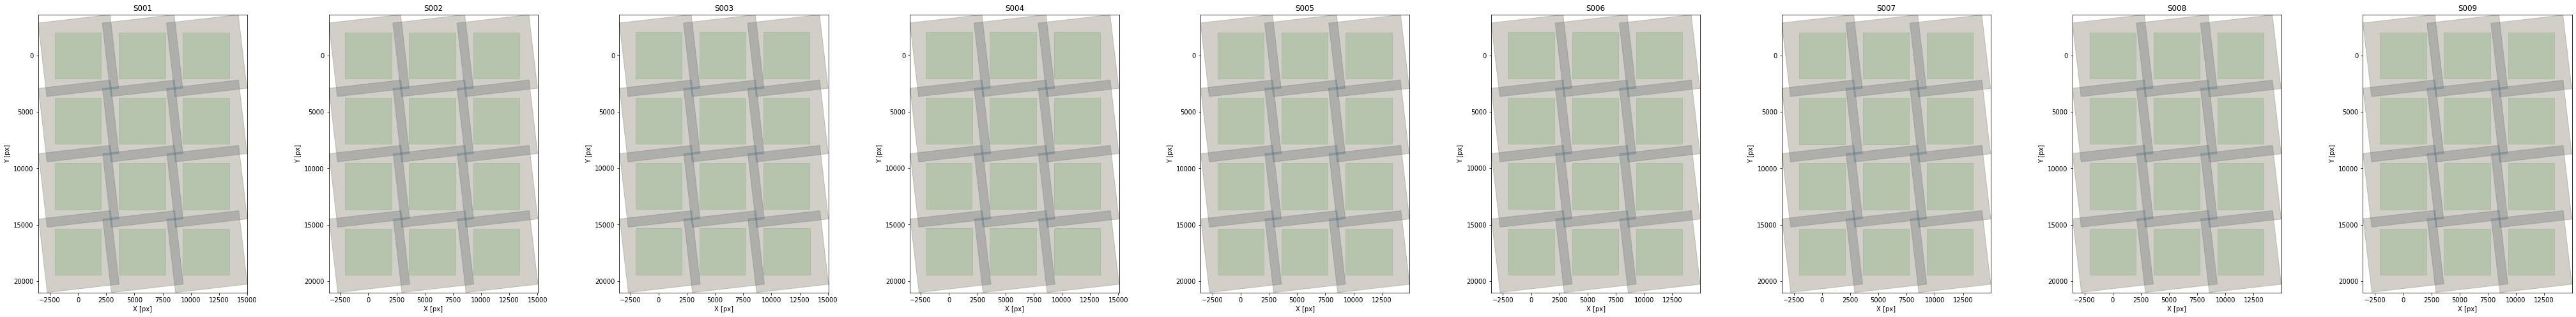

In [604]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid
sections_2_plot = df_project['sectionId'].unique().tolist()

# Set up figure
ncols = len(sections_2_plot)
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
axmap = {k: v for k, v in zip(sections_2_plot, axes.flat)}
cmap = {k: v for k, v in zip(stacks_2_plot, sns.color_palette(n_colors=len(stacks_2_plot)))}

# Iterate through layers
df_stacks = create_stacks_DataFrame(stacks_2_plot,
                                    render=render)
for sectionId, layer in tqdm_notebook(df_stacks.groupby('sectionId')):
    # Collect all tiles in each layer to determine bounds
    boxes = []
    # Set axis
    ax = axmap[sectionId]

    # Loop through tilesets within each layer
    for stack, tileset in layer.groupby('stack'):

        # Loop through each tile
        for i, tile in tileset.iterrows():

            # Create `shapely.box` resembling raw image tile
            b = box(0, 0, tile['width'], tile['height'])
            # Apply transforms to `shapely.box`
            for tform in tile['transforms']:
                A = (tform.M[:2, :2].ravel().tolist() +
                     tform.M[:2,  2].ravel().tolist())
                b = affinity.affine_transform(b, A)
            boxes.append(b)
            # Get coordinates of `shapely.box` to plot matplotlib polygon patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=cmap[stack], alpha=0.2)
            ax.add_patch(p)
            
    # Axis aesthetics
    ax.set_title(sectionId)
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    # Determine bounds
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.invert_yaxis()
    ax.set_aspect('equal')

### Render images

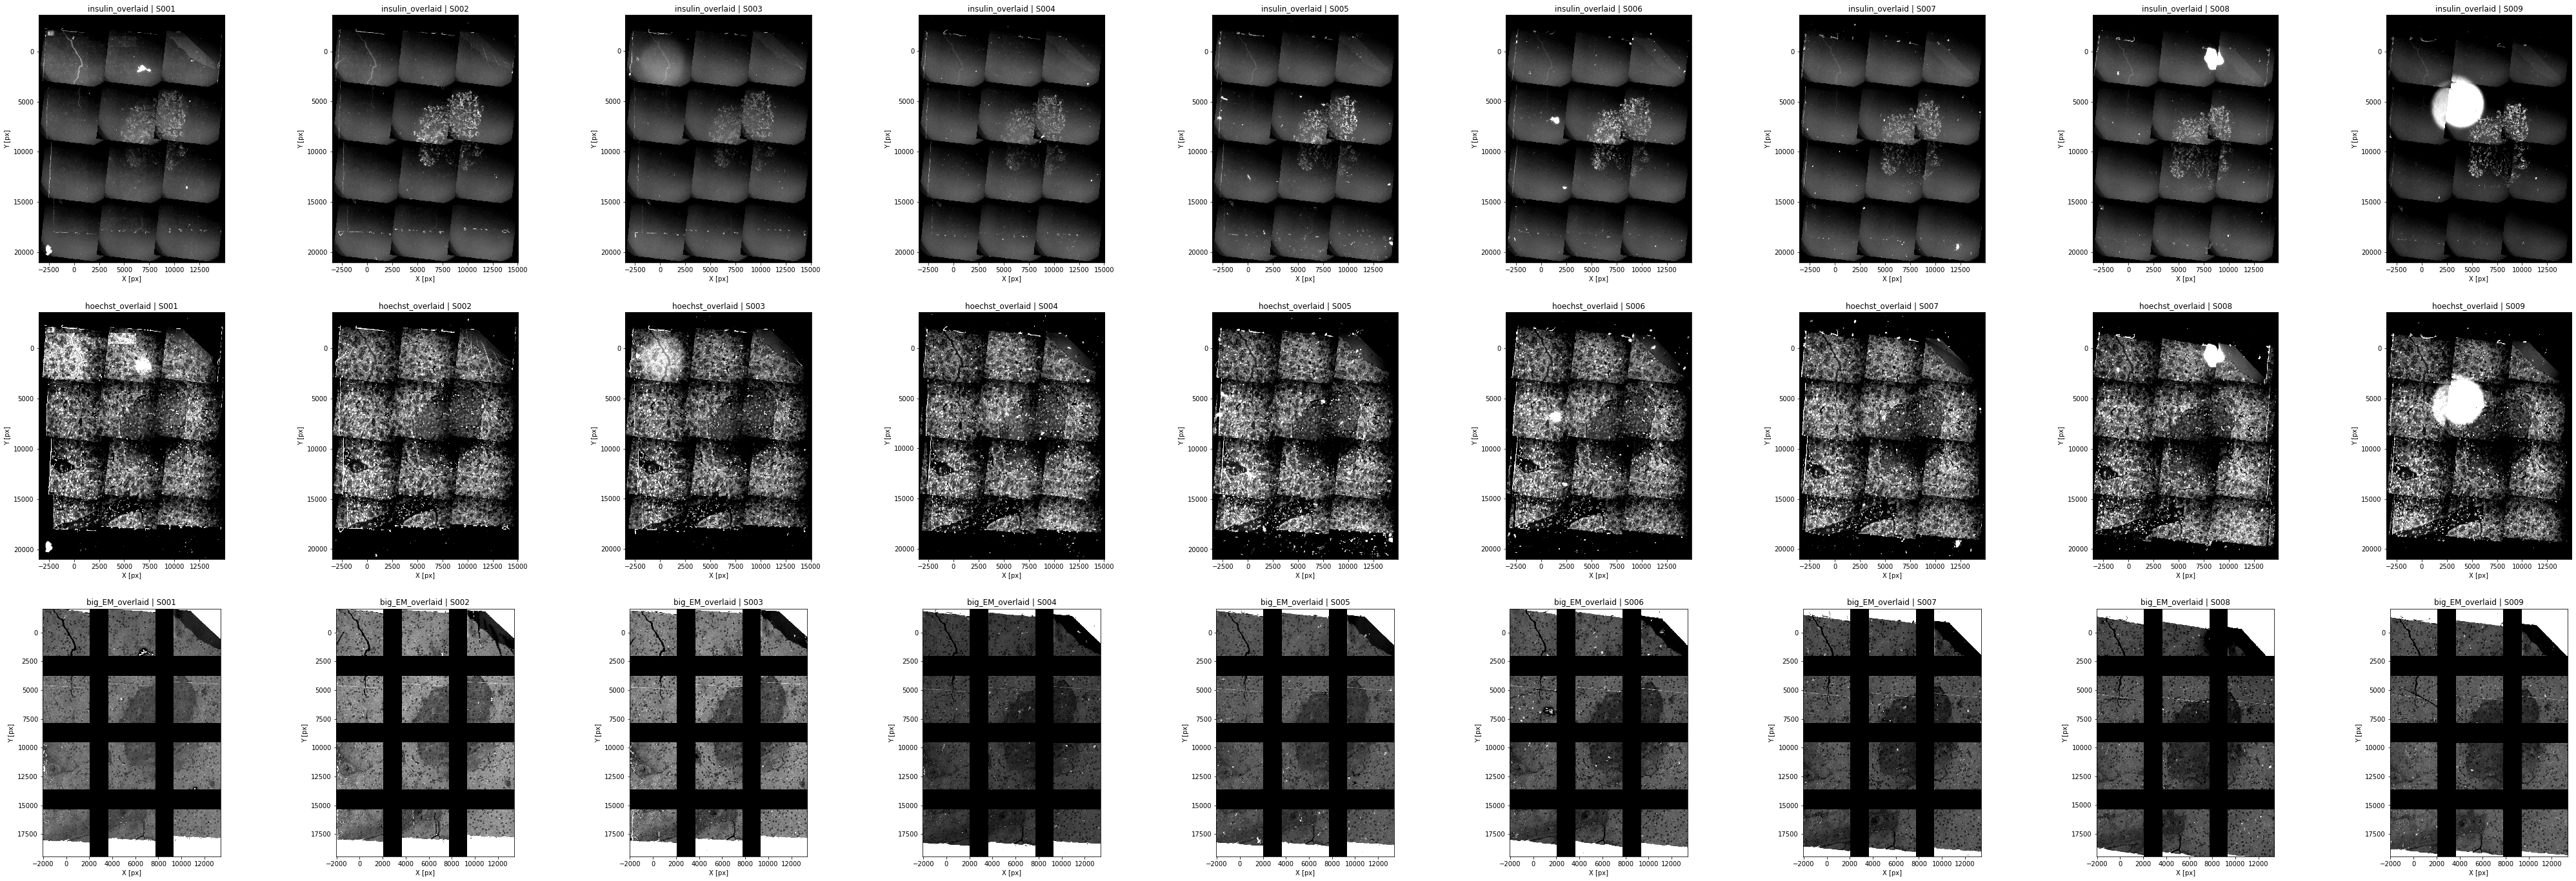

In [605]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid
sections_2_plot = df_project['sectionId'].unique().tolist()

# Set up figure
nrows = len(stacks_2_plot)
ncols = len(sections_2_plot)
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows))
axmap = {k: v for k, v in zip(product(stacks_2_plot, sections_2_plot), axes.flat)}
cmap = {k: v for k, v in zip(stacks_2_plot, sns.color_palette(n_colors=len(stacks_2_plot)))}

# Iterate through layers
df_stacks = create_stacks_DataFrame(stacks_2_plot,
                                    render=render)
for (stack, sectionId), tileset in tqdm_notebook(df_stacks.groupby(['stack', 'sectionId'])):

    # Set axis
    ax = axmap[(stack, sectionId)]
    # Fetch tileset image
    z = tileset['z'].iloc[0]
    bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                               z=z,
                                               render=render)
    scale = 1024 / np.max([bounds['maxX'] - bounds['minX'],
                           bounds['maxY'] - bounds['minY']])
    image = renderapi.image.get_section_image(stack=stack,
                                              z=z,
                                              scale=scale,
                                              maxTileSpecsToRender=30,
                                              render=render)
    # Plot
    extent = [bounds['minX'],  # left
              bounds['maxX'],  # right
              bounds['minY'],  # bottom
              bounds['maxY']]  # top
    ax.imshow(image, extent=extent, origin='lower')
    # Axis aesthetics
    ax.set_title(f"{stack} | {sectionId}")
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.set_xlim()
    ax.invert_yaxis()